In [1]:
import pandas as pd
import numpy as np 

In [2]:
# Import Data 
data = pd.read_excel('spx_returns_weekly.xlsx', sheet_name= 2, index_col="date")
df = data[['AAPL', 'META', 'NVDA', 'TSLA']]
df.head()

,AAPL,META,NVDA,TSLA
date,,,,
2015-01-09,0.024514,-0.009055,-0.009315,-0.057685
2015-01-16,-0.053745,-0.032931,0.000836,-0.065760
2015-01-23,0.065950,0.035255,0.037578,0.042575
2015-01-30,0.036997,-0.024669,-0.072636,0.011476
2015-02-06,0.019114,-0.018967,0.062269,0.067589


# 1. Diversification

## 1.1: Volatility, and Empirical VaR and CVaR

In [3]:
# Weekly Volatility
vol_weekly = df.std()

# Empirical VaR Over a Week's Horizon
VaR_empirical = df.apply(lambda x: np.quantile(x, 0.05))

# Empirical CVaR Over a Week's Horizon
CVaR_empirical = df.apply(lambda x: x[x < np.quantile(x, 0.05)]).mean()

# Results 

risk_metrics = pd.DataFrame({
    'Weekly Volatility': vol_weekly,
    'VaR (5%)': VaR_empirical,
    'CVaR (5%)': CVaR_empirical
})

risk_metrics.style.format("{:.3f}")

,Weekly Volatility,VaR (5%),CVaR (5%)
AAPL,0.038,-0.056,-0.083
META,0.049,-0.070,-0.103
NVDA,0.064,-0.087,-0.116
TSLA,0.081,-0.117,-0.148


## 1.2: Equally Weighted Portfolio and Risk Metrics

In [4]:
# Form Equally Weighted Portfolio 
n = len(df.columns)
weights = np.ones(n)/n
port_ew =  df @ weights
port_ew.head()

date
2015-01-09   -0.012885
2015-01-16   -0.037900
2015-01-23    0.045340
2015-01-30   -0.012208
2015-02-06    0.032501
dtype: float64

In [5]:
# Portfolio VaR
VaR_port_ew = np.quantile(port_ew, 0.05)
# Portfolio CVaR
CVaR_port_ew = port_ew[port_ew < np.quantile(port_ew, 0.05)].mean()

# Print result
print(f'The VaR of the portfolio is {VaR_port_ew:.3f}.\nThe CVaR is {CVaR_port_ew:.3f}.')

The VaR of the portfolio is -0.062.
The CVaR is -0.085.


The portfolio’s VaR and CVaR (−0.062 and −0.085, respectively) are less negative than those of any individual asset, except AAPL. This indicates that the portfolio has a smaller downside risk at the 5% level despite being composed entirely of volatile stocks with equal weights. This is driven by diversification among imperfectly correlated assets.

## 1.3: Drop Most Volatile Asset

In [6]:
# Most Volatile Asset 
vol_asset = vol_weekly.idxmax()
print(vol_asset)

# Portfolio with Dropped Asset 
remaining_assets = vol_weekly.index.drop(vol_asset)
weights = np.ones(len(remaining_assets)) / (len(remaining_assets) + 1)
port_dropped_asset = df[remaining_assets] @ weights

# Calculate VaR and CVaR
VaR_dropped_asset = np.quantile(port_dropped_asset, 0.05)
CVaR_dropped_asset = port_dropped_asset[port_dropped_asset < np.quantile(port_dropped_asset, 0.05)].mean()

# Print result
print(f'The VaR of the portfolio with the most volatile asset dropped is {VaR_dropped_asset:.3f}.\nThe CVaR is {CVaR_dropped_asset:.3f}.')


TSLA
The VaR of the portfolio with the most volatile asset dropped is -0.042.
The CVaR is -0.061.


In [7]:
VaR_change = pd.DataFrame({
    'Equal Weights': [VaR_port_ew, CVaR_port_ew],
    'Dropped Weights': [VaR_dropped_asset, CVaR_dropped_asset]
}, index=['VaR', 'CVaR'])

VaR_change['Percentage Change (%)'] = (
    (VaR_change['Dropped Weights'] - VaR_change['Equal Weights'])
    / VaR_change['Equal Weights'].abs()
) * 100

VaR_change


,Equal Weights,Dropped Weights,Percentage Change (%)
VaR,-0.061950,-0.042463,31.456696
CVaR,-0.084992,-0.060531,28.780471


The most volatile asset, TSLA, increases the portfolio’s tail risk by roughly 30%, as seen in both VaR and CVaR. Although TSLA’s stand-alone VaR (−0.117) and CVaR (−0.148) are much higher in magnitude than the portfolio’s, its marginal contribution to overall risk is smaller because diversification offsets part of its volatility.

# 2: Dynamic Measures

## 2.1: Volatility, Mean, VaR and CVaR

In [8]:
# Calculate Rolling Volatility (window = 26)
sigma_t = df.shift(1).rolling(window=26).std()
sigma_t.tail()

,AAPL,META,NVDA,TSLA
date,,,,
2025-04-25,0.046115,0.051540,0.076226,0.100697
2025-05-02,0.047947,0.054819,0.078598,0.097651
2025-05-09,0.047564,0.057596,0.078556,0.096224
2025-05-16,0.047741,0.057173,0.076363,0.077772
2025-05-23,0.049628,0.057751,0.082727,0.084876


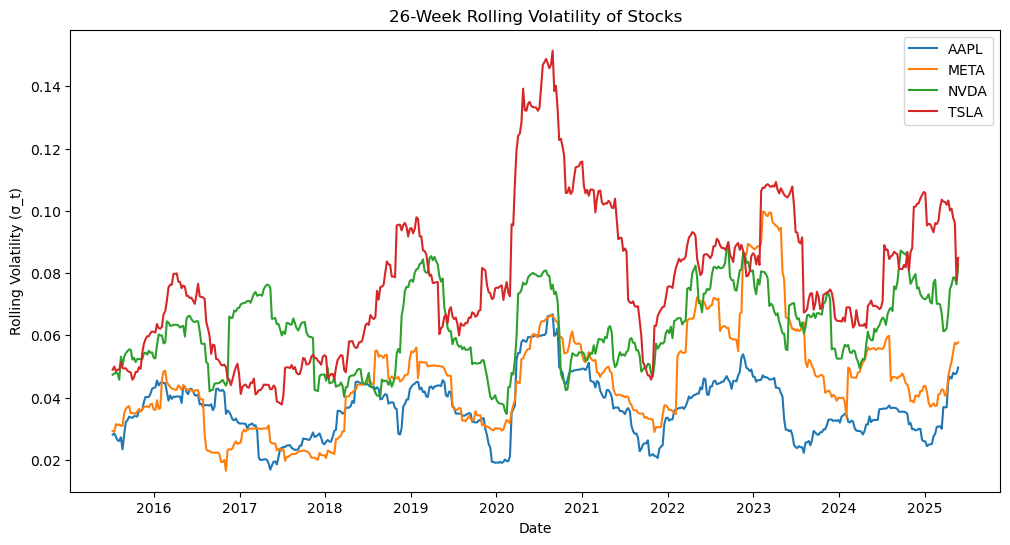

In [9]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(12,6))

for col in sigma_t.columns:
    plt.plot(sigma_t.index, sigma_t[col], label=col)

plt.xlabel('Date')
plt.ylabel('Rolling Volatility (σ_t)')
plt.title('26-Week Rolling Volatility of Stocks')
plt.legend()  # show legend
plt.show()

In [10]:
# Calculate VaR
z = -1.65
VaR_last_date = pd.DataFrame([z * sigma_t.iloc[-1]], index=["VaR (Weekly)"])
VaR_last_date

,AAPL,META,NVDA,TSLA
VaR (Weekly),-0.081886,-0.09529,-0.136499,-0.140046


In [11]:
from scipy.stats import norm 
alpha=0.05
# Calculate CVaR
z = -1.65
CVaR_last_date = pd.DataFrame([-sigma_t.iloc[-1] * norm.pdf(z)/alpha], index=["CVaR (Weekly)"])
CVaR_last_date

,AAPL,META,NVDA,TSLA
CVaR (Weekly),-0.101504,-0.118119,-0.169201,-0.173598


Parametric rolling VaR/CVaR use only the last 26 weeks and assume normality, while historical VaR/CVaR use the full sample. As a result, the parametric estimates are generally larger in magnitude, reflecting higher tail risk in recent periods toward the end of the sample.

## 2.2: Backtest VaR (Hit Test)

In [12]:
# Rolling Volatility: VaR
total_sample_var_rolling = sigma_t * z

# Expanding Volatility
sigma_t_expanding = df.expanding(min_periods=2).std()
total_sample_var_expanding = sigma_t_expanding * z

In [13]:
# Hit Rate
hit_rate_rolling = (total_sample_var_rolling > df).sum() / len(df) * 100
hit_rate_expanding = (total_sample_var_expanding > df).sum() / len(df) * 100

hit_results = pd.DataFrame({
    "Expanding VaR Hit Rate": hit_rate_rolling,
    "Rolling VaR Hit Rate": hit_rate_expanding
}, index = df.columns)

hit_results

,Expanding VaR Hit Rate,Rolling VaR Hit Rate
AAPL,4.981550,4.243542
META,4.243542,4.797048
NVDA,4.243542,3.136531
TSLA,4.981550,6.457565


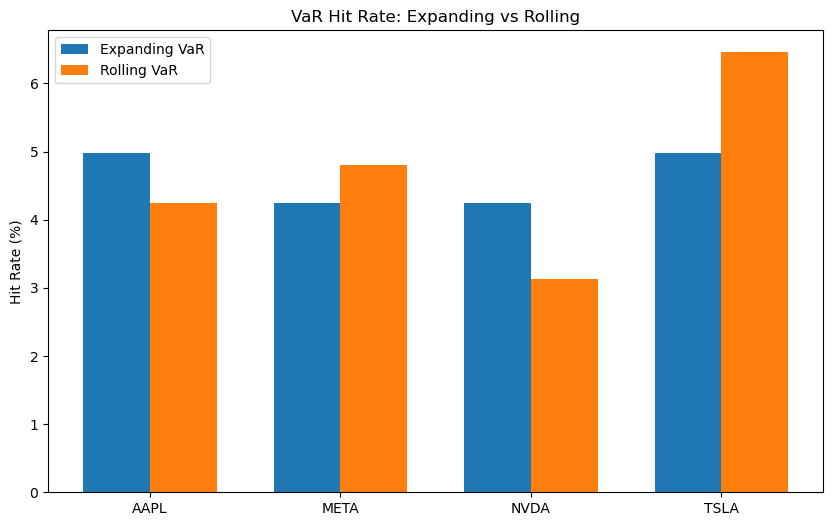

In [14]:
# Set up figure
plt.figure(figsize=(10,6))

# X-axis positions
x = np.arange(len(df.columns))

# Bar width
width = 0.35

# Plot bars
plt.bar(x - width/2, hit_results['Expanding VaR Hit Rate'], width, label='Expanding VaR')
plt.bar(x + width/2, hit_results['Rolling VaR Hit Rate'], width, label='Rolling VaR')

# Labels and title
plt.xticks(x, df.columns)
plt.ylabel('Hit Rate (%)')
plt.title('VaR Hit Rate: Expanding vs Rolling')
plt.legend()

plt.show()